In [4]:
import pandas as pd
import numpy as np
import sqlite3
import os
import sys
import folium
import folium.plugins
import osmnx
import geopandas as gpd
import sklearn
import scipy
from matplotlib import pyplot as plt
import pickle
from shapely.geometry import Point, LineString, Polygon, MultiPoint, MultiPolygon
from shapely.ops import unary_union, nearest_points
import time

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import pairwise_distances

import itertools
! pip install anytree
import anytree
from anytree import Node, RenderTree

pd.options.display.max_rows = 4000
np.set_printoptions(threshold=sys.maxsize)

osmnx.config(use_cache=True, log_console=True)

from helpers import *

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


/home/till/.local/lib/python3.10/site-packages/osmnx/utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


# fetch data

In [5]:
# for other countries see below

points = pd.read_csv('german_points.csv', index_col=0)
places = places_from_points(points)
places_before = places

# EXAMPLE GERMANY

In [6]:
# tracking
stats = {}
stats['spots_before'] = len(places)
stats['spots_after'] = 0

stats['merged_spots'] = 0
stats['merges'] = 0
stats['merged_spots_service_station'] = []
stats['merges_service_station'] = 0
stats['merged_spots_gas_station'] = []
stats['merges_gas_station'] = 0
stats['merged_spots_parking_lot'] = []
stats['merges_parking_lot'] = 0
stats['merged_spots_proximity'] = 0
stats['merges_proximity'] = 0
stats['merged_spots_road_segment'] = 0
stats['merges_road_segment'] = 0

stats['adjusted_spots'] = 0
stats['adjusted_spots_service_station'] = 0
stats['adjusted_spots_gas_station'] = 0
stats['adjusted_spots_parking_lot'] = 0
stats['adjusted_spots_road_segment'] = 0

stats['deleted_spots'] = 0



In [7]:
n_clusters = 100

X = np.array(places[['lon','lat']])
M = pairwise_distances(X,X, metric=haversine, n_jobs=-1)

clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='average', compute_distances=True, affinity='precomputed')
clustering.fit(M)
places['cluster'] = clustering.labels_

# to filter out places that have already been changed
places_at_features = []

In [8]:
places = gpd.GeoDataFrame(places, geometry=gpd.points_from_xy(places.lon, places.lat), crs='EPSG:4326')

## 1-3

In [9]:
services_threshold = 30
fuel_threshold = 30
parking_threshold = 30

In [10]:
# inspired by https://github.com/gboeing/osmnx/blob/3822ed659f1cc9f426a990c02dd8ca6b3f4d56d7/osmnx/utils_geo.py#L420
def circle(row, dist):
    point = row.geometry
    earth_radius = 6_371_009  # meters
    delta_lat = (dist / earth_radius) * (180 / np.pi)
    return point.buffer(delta_lat)

places['services_geometry'] = places.apply(lambda row: circle(row, services_threshold), axis=1)
places['fuel_geometry'] = places.apply(lambda row: circle(row, fuel_threshold), axis=1)
places['parking_geometry'] = places.apply(lambda row: circle(row, parking_threshold), axis=1)

places['service_corrected'] = None
places['fuel_corrected'] = None
places['parking_corrected'] = None
places['port'] = None

### run

In [11]:
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.simplefilter(action='ignore', category=ShapelyDeprecationWarning)

# runs 10 min

def get_close_feature(geometry, features):
    this = features[features.intersects(geometry)]    
    if not this.empty:
        # immediatelly get to corrected position
        this = this.iloc[0]
        return this.geometry.centroid
    else:
        return None
    
def correct_points(row):
    corrections = row[['services_corrected', 'fuel_corrected', 'parking_corrected']]
    corrections = [c for c in corrections if c is not None]
    if len(corrections) > 0:
        new_location = corrections[0]
        places_at_features.append(new_location)
        points.loc[(points.lat == row.lat) & (points.lon == row.lon), ['lat','lon']] = [new_location.y, new_location.x]

        # stats
        if row.services_corrected is not None:
            stats['merged_spots_service_station'].append(new_location)
        elif row.fuel_corrected is not None:
            stats['merged_spots_gas_station'].append(new_location)
        elif row.parking_corrected is not None:
            stats['merged_spots_parking_lot'].append(new_location)
        else:
            pass
    else:
        if row.port is not None:
            places_at_features.append(row.geometry)


for i in range(0,n_clusters):
    current_cluster = places.loc[places.cluster == i]
    # choose largest geometry ...
    polys = MultiPolygon(current_cluster.services_geometry.to_list())
    current_region = polys.convex_hull

    start = time.time()

    services = osmnx.geometries.geometries_from_polygon(current_region, tags={'highway':'services'})
    fuel_parking = osmnx.geometries.geometries_from_polygon(current_region, tags={'amenity':['parking','fuel']})
    port = osmnx.geometries.geometries_from_polygon(current_region, tags={'industrial':'port'})

    print(time.time()-start)
    start = time.time()
    
    try:
        services = services.loc['way']
        places.loc[places.cluster == i, 'services_corrected'] = current_cluster.apply(lambda row: get_close_feature(row.services_geometry, services), axis=1)
    except:
        pass
    
    if not fuel_parking.empty:      
        fuel = fuel_parking.loc[fuel_parking.amenity == 'fuel']
        parking = fuel_parking.loc[fuel_parking.amenity == 'parking']    
    
        places.loc[places.cluster == i, 'fuel_corrected'] = current_cluster.apply(lambda row: get_close_feature(row.fuel_geometry, fuel), axis=1)
        places.loc[places.cluster == i, 'parking_corrected'] = current_cluster.apply(lambda row: get_close_feature(row.parking_geometry, parking), axis=1)
    
    if not port.empty:
        places.loc[places.cluster == i, 'port'] = current_cluster.apply(lambda row: get_close_feature(row.geometry, port), axis=1)

    print(time.time()-start)
    print(i, "th cluster")

places.apply(correct_points, axis=1)
# rerun fetching the places

def count_adjustments(data):
    pre_len = len(data)
    data = [item for item in data if data.count(item) > 1]
    post_len = len(data)
    return data, pre_len - post_len

def count_merging(data):
    spots = len(data)
    result = [] 
    [result.append(x) for x in data if x not in result] 
    merges = len(result)
    return merges, spots

# stats
stats['merged_spots_service_station'], stats['adjusted_spots_service_station'] = count_adjustments(stats['merged_spots_service_station'])
stats['merged_spots_gas_station'], stats['adjusted_spots_gas_station'] = count_adjustments(stats['merged_spots_gas_station'])
stats['merged_spots_parking_lot'], stats['adjusted_spots_parking_lot'] = count_adjustments(stats['merged_spots_parking_lot'])

stats['merges_service_station'], stats['merged_spots_service_station'] = count_merging(stats['merged_spots_parking_lot'])
stats['merges_gas_station'], stats['merged_spots_gas_station'] = count_merging(stats['merged_spots_gas_station'])
stats['merges_parking_lot'], stats['merged_spots_parking_lot'] = count_merging(stats['merged_spots_parking_lot'])

stats['merges'] += stats['merges_service_station'] + stats['merges_gas_station'] + stats['merges_parking_lot']
stats['merged_spots'] += stats['merged_spots_service_station'] + stats['merged_spots_gas_station'] + stats['merged_spots_parking_lot']
stats['adjusted_spots'] += stats['adjusted_spots_service_station'] + stats['adjusted_spots_gas_station'] + stats['adjusted_spots_parking_lot']


0.6153883934020996
0.10947346687316895
0 th cluster


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


1.5164830684661865
0.1929457187652588
1 th cluster


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


9.443122386932373


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


0.8098263740539551
2 th cluster
2.2623233795166016


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


0.4815332889556885
3 th cluster
0.8515830039978027
0.09433484077453613
4 th cluster


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


0.8758237361907959
0.13242173194885254
5 th cluster


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


2.484302282333374


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


0.23063969612121582
6 th cluster
1.1903562545776367


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will

0.20493316650390625
7 th cluster
1.377492904663086
0.17304468154907227
8 th cluster


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


0.7301065921783447
0.045907020568847656
9 th cluster


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


0.5670087337493896
0.05698442459106445
10 th cluster


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


1.3142316341400146
0.13958120346069336
11 th cluster


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


2.1314477920532227


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


0.232802152633667
12 th cluster
1.426342248916626


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


0.20563840866088867
13 th cluster
4.122815370559692


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


0.508289098739624
14 th cluster
0.2347736358642578
0.043562889099121094
15 th cluster
0.28476977348327637
0.015923500061035156
16 th cluster


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


0.554640531539917
0.05760312080383301
17 th cluster


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


0.6423890590667725
0.06922245025634766
18 th cluster


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


0.350078821182251
0.04748106002807617
19 th cluster


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


0.5117456912994385
0.049952030181884766
20 th cluster


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


1.8173651695251465
0.13246822357177734
21 th cluster


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


0.48677587509155273
0.0722358226776123
22 th cluster


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


3.4008734226226807


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


0.3243565559387207
23 th cluster
5.5704123973846436


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


0.9490916728973389
24 th cluster
1.9895050525665283


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


0.42804551124572754
25 th cluster
0.1401197910308838
0.030133962631225586
26 th cluster


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


0.6444385051727295
0.09801268577575684
27 th cluster


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


0.4315943717956543
0.04292607307434082
28 th cluster


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


0.4740734100341797
0.03337430953979492
29 th cluster


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


0.6201286315917969
0.07237696647644043
30 th cluster


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


0.7197792530059814
0.14266252517700195
31 th cluster


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


0.7389810085296631
0.13494396209716797
32 th cluster


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


0.6681151390075684
0.09535956382751465
33 th cluster


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


0.2791481018066406
0.05841493606567383
34 th cluster
0.12998390197753906


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


0.01327967643737793
35 th cluster
1.15983247756958


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


0.30776143074035645
36 th cluster
0.5957615375518799
0.05626702308654785
37 th cluster


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


0.3642001152038574
0.062068939208984375
38 th cluster


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


0.7765803337097168
0.08386921882629395
39 th cluster


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


1.203336477279663


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


0.2969791889190674
40 th cluster
0.21041345596313477
0.04560112953186035
41 th cluster


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


1.4946835041046143
0.17867112159729004
42 th cluster


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


0.3954148292541504
0.07210111618041992
43 th cluster


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


2.662393569946289


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


0.37638235092163086
44 th cluster
0.3019731044769287
0.08020377159118652
45 th cluster


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


3.274775743484497


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


0.283672571182251
46 th cluster
0.285078763961792
0.053313493728637695
47 th cluster


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


0.539193868637085
0.06346607208251953
48 th cluster


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


0.37885308265686035
0.10129690170288086
49 th cluster


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


0.4041869640350342
0.049193620681762695
50 th cluster
0.08203458786010742
5.340576171875e-05
51 th cluster


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


0.22409915924072266
0.05494499206542969
52 th cluster
0.08491253852844238
4.839897155761719e-05
53 th cluster


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


0.7786543369293213
0.10526108741760254
54 th cluster


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


1.0930442810058594


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


0.22557687759399414
55 th cluster
1.7789220809936523
0.20192217826843262
56 th cluster


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


0.7724506855010986
0.14361834526062012
57 th cluster


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


0.3736274242401123
0.029277563095092773
58 th cluster


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


0.8499951362609863
0.13749957084655762
59 th cluster


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


0.7161247730255127
0.0944986343383789
60 th cluster


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


0.12762117385864258
0.014559745788574219
61 th cluster
0.16050004959106445


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


0.04203438758850098
62 th cluster
1.1640174388885498


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


0.24311280250549316
63 th cluster
0.12658047676086426
0.019504308700561523
64 th cluster


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


1.7660677433013916
0.18230199813842773
65 th cluster


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


0.08647274971008301
4.172325134277344e-05
66 th cluster
0.6202285289764404
0.08646464347839355
67 th cluster


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


0.6341357231140137
0.06093144416809082
68 th cluster


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


0.4022231101989746
0.06082773208618164
69 th cluster


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


0.16160941123962402
0.012898445129394531
70 th cluster
0.20290541648864746
0.019945383071899414
71 th cluster


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


0.6141881942749023
0.04893827438354492
72 th cluster


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


0.31568074226379395
0.0435481071472168
73 th cluster
0.0906679630279541
0.008871078491210938
74 th cluster


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will

1.0796403884887695


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


0.2619023323059082
75 th cluster
0.187089204788208


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


0.0168612003326416
76 th cluster
0.3396897315979004
0.03454470634460449
77 th cluster


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


0.5130643844604492
0.09825253486633301
78 th cluster


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


0.2669816017150879
0.03771615028381348
79 th cluster
0.1316518783569336
0.015528202056884766
80 th cluster


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will

0.1924130916595459
0.014327526092529297
81 th cluster


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


0.6192426681518555
0.06941866874694824
82 th cluster


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


0.5778002738952637
0.08826661109924316
83 th cluster


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


0.36027979850769043
0.07563471794128418
84 th cluster


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


0.6201846599578857
0.08260965347290039
85 th cluster


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


0.23899173736572266
0.03970742225646973
86 th cluster


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


2.8727898597717285


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


0.40953564643859863
87 th cluster
0.2364063262939453
0.05333995819091797
88 th cluster


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


0.24123716354370117
0.06244301795959473
89 th cluster


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


0.8756067752838135
0.19613003730773926
90 th cluster


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


0.22714900970458984
0.03527235984802246
91 th cluster
0.11975526809692383
0.018507957458496094
92 th cluster


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


0.30441951751708984
0.050042152404785156
93 th cluster
0.10721921920776367
0.011128664016723633
94 th cluster


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will

0.08462262153625488
4.76837158203125e-05
95 th cluster
0.3251814842224121
0.034726619720458984
96 th cluster
0.15779948234558105


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will

0.023606538772583008
97 th cluster
0.35378432273864746
0.06914401054382324
98 th cluster
0.07760763168334961
4.839897155761719e-05
99 th cluster


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


## 4

In [12]:
places = places_from_points(points)
places = gpd.GeoDataFrame(places, geometry=gpd.points_from_xy(places.lon, places.lat), crs='EPSG:4326')

In [13]:
# calculate again because places are changed now
X = np.array(places[['lon','lat']])
M = pairwise_distances(X,X, metric=haversine, n_jobs=-1)

clustering = AgglomerativeClustering(n_clusters=None, linkage='single', compute_distances=True, affinity='precomputed', distance_threshold=0.05)
clustering.fit(M)

AgglomerativeClustering(affinity='precomputed', compute_distances=True,
                        distance_threshold=0.05, linkage='single',
                        n_clusters=None)

In [14]:
# !!! are cluster distances in meter here?
merge_threshold = 50

close_links = clustering.children_[clustering.distances_ < merge_threshold/1000]

# establish tree of spots
# each subtree contains spots that are sufficiently close to each other
a = [0] * 2 * len(places)
root = Node('root')

ii = itertools.count(len(places))
for x in close_links:
    num = next(ii)
    a[num] = Node(num, parent=root)
    if x[0] < len(places):
        a[x[0]] = Node(x[0], parent=a[num])
    else:
        a[x[0]].parent = a[num]
    
    if x[1] < len(places):
        a[x[1]] = Node(x[1], parent=a[num])
    else:
        a[x[1]].parent = a[num]


In [15]:
# find the clusters
clusters = []
for subtree in root.children:
    cluster = []
    for leaf in subtree.leaves:
        cluster.append(leaf.name)
    clusters.append(cluster)

# merge points
for cluster in clusters:
    merged_spot = places.iloc[cluster].geometry.unary_union.centroid
    lat = merged_spot.y
    lon = merged_spot.x
    
    stats['merges'] += 1
    stats['merges_proximity'] += 1
    for spot in cluster:
        spot = places.iloc[spot]
        points.loc[(points.lat == spot.lat) & (points.lon == spot.lon), ['lat','lon']] = [lat,lon]

        stats['merged_spots'] += 1
        stats['merged_spots_proximity'] += 1 

# rerun fetching the places

## 5-9

In [16]:
places = places_from_points(points)
places = gpd.GeoDataFrame(places, geometry=gpd.points_from_xy(places.lon, places.lat), crs='EPSG:4326')
places['at_road'] = places.apply(lambda row: not (row.geometry in places_at_features), axis=1)
places.to_crs('EPSG:3857', inplace=True)

places[['nearest_road','road_correction']] = None, None

In [17]:
def cut(line, distance):
    # Cuts a line in two at a distance from its starting point
    if distance <= 0.0 or distance >= line.length:
        return [LineString(line)]
    coords = list(line.coords)
    for i, p in enumerate(coords):
        pd = line.project(Point(p))
        if pd == distance:
            return [
                LineString(coords[:i+1]),
                LineString(coords[i:])]
        if pd > distance:
            cp = line.interpolate(distance)
            return [
                LineString(coords[:i] + [(cp.x, cp.y)]),
                LineString([(cp.x, cp.y)] + coords[i:])]

### run

In [18]:
# little faster than above, but more api queries

road_upper_threshold = 100
road_lower_threshold = 30
road_search_radius = 300

counter = itertools.count(0)
def get_nearest_road(row):   
    print(next(counter)) 
    try:
        N = osmnx.graph_from_point((row.lat, row.lon), dist=road_search_radius, network_type='drive', retain_all=True, truncate_by_edge=True)
        N = osmnx.projection.project_graph(N, to_crs='epsg:3857')
        nearest = osmnx.distance.nearest_edges(N, row.geometry.x, row.geometry.y, return_dist=True)
        road = nearest[0]
        dist = nearest[1]   
        road_name = str(road[0]) + "-" + str(road[0])  

        if dist > road_upper_threshold:
            return None, None        
        elif road_lower_threshold < dist <= road_upper_threshold:
            # get the coordinates of new spot that is moved closer to the road than original spot
            _, gdf_edges = osmnx.utils_graph.graph_to_gdfs(N)          
            road_geom = gdf_edges.loc[road].geometry
            nearest_point = nearest_points(row.geometry, road_geom)[1]
            tangent_line = LineString([nearest_point, row.geometry])
            cut_line = cut(tangent_line, road_lower_threshold)
            return road_name, Point(cut_line[0].coords[-1])
        else:
            return road_name, None        
    except:
        return None, None

places.loc[places.at_road, 'nearest_road'], places.loc[places.at_road, 'road_correction'] = zip(*places.loc[places.at_road].apply(lambda x: get_nearest_road(x), axis=1))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
# delete spots
def delete_unrelated_spots(row):
    if row.nearest_road is None and row.at_road:
        global points
        global stats
        stats['deleted_spots'] += 1
        deletions = points.loc[(points.lat == row.lat) & (points.lon == row.lon)].index      
        points = points.drop(deletions, axis=0)
        
places.apply(delete_unrelated_spots, axis=1)
print("done")

done


In [ ]:
# correct spots

import pyproj

source_crs = 'epsg:3857' # Mercator projection
target_crs = 'epsg:4326' # Global lat-lon coordinate system

crs_transformer = pyproj.Transformer.from_crs(source_crs, target_crs)

places.to_crs('EPSG:4326', inplace=True)

places['merged_to_road'] = False

def attach_spot_to_road_virtually(row):
    if row.road_correction is not None:
        lat, lon = crs_transformer.transform(row.road_correction.x, row.road_correction.y)
        return Point(lon, lat)
    else:
        return row.geometry

places['geometry'] = places.apply(attach_spot_to_road_virtually, axis=1)
print("done")

done


/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [ ]:
from itertools import chain

places['id'] = places.index
g = places.groupby('nearest_road')
clusters = list(filter(lambda x: len(x) > 1, g.id.apply(list).to_list()))

spots_to_be_merged = list(chain.from_iterable(clusters))
places.loc[spots_to_be_merged, 'merged_to_road'] = True

# mind loc vs iloc here in comparision to the first version
for cluster in clusters:
    merged_spot = places.loc[cluster].geometry.unary_union.centroid
    lat = merged_spot.y
    lon = merged_spot.x

    stats['merges'] += 1
    stats['merges_road_segment'] += 1
    for spot in cluster:
        spot = places.loc[spot]
        points.loc[(points.lat == spot.lat) & (points.lon == spot.lon), ['lat','lon']] = [lat,lon]

        stats['merged_spots'] += 1
        stats['merged_spots_road_segment'] += 1

In [ ]:
# really do it for those that have not been merged

def attach_spot_to_road(row):
    if row.road_correction is not None and not row.merged_to_road:
        points.loc[(points.lat == row.lat) & (points.lon == row.lon), ['lat','lon']] = [row.geometry.y, row.geometry.x]

        stats['adjusted_spots'] += 1
        stats['adjusted_spots_road_segment'] += 1
    

places.apply(attach_spot_to_road, axis=1)
print("done")

done


In [ ]:
places = places_from_points(points)
stats['spots_after'] = len(places)
places_after = places

{'spots_before': 2745, 'spots_after': 2448, 'merged_spots': 229, 'merges': 105, 'merged_spots_service_station': 30, 'merges_service_station': 14, 'merged_spots_gas_station': 13, 'merges_gas_station': 6, 'merged_spots_parking_lot': 30, 'merges_parking_lot': 14, 'merged_spots_proximity': 110, 'merges_proximity': 48, 'merged_spots_road_segment': 46, 'merges_road_segment': 23, 'adjusted_spots': 1019, 'adjusted_spots_service_station': 291, 'adjusted_spots_gas_station': 175, 'adjusted_spots_parking_lot': 369, 'adjusted_spots_road_segment': 184, 'deleted_spots': 88}


In [ ]:
# SUMMARY
import pprint
pprint.pprint(stats, sort_dicts=False)

{'spots_before': 2745,
 'spots_after': 2448,
 'merged_spots': 229,
 'merges': 105,
 'merged_spots_service_station': 30,
 'merges_service_station': 14,
 'merged_spots_gas_station': 13,
 'merges_gas_station': 6,
 'merged_spots_parking_lot': 30,
 'merges_parking_lot': 14,
 'merged_spots_proximity': 110,
 'merges_proximity': 48,
 'merged_spots_road_segment': 46,
 'merges_road_segment': 23,
 'adjusted_spots': 1019,
 'adjusted_spots_service_station': 291,
 'adjusted_spots_gas_station': 175,
 'adjusted_spots_parking_lot': 369,
 'adjusted_spots_road_segment': 184,
 'deleted_spots': 88}


In [ ]:
print(f"Spots reduced from {stats['spots_before']} to {stats['spots_after']}")
print(f"{stats['merges']} times spots were merged together into a newly generated spot, including {stats['merges_service_station']} times on a service station, {stats['merges_gas_station']} times on a gas station, {stats['merges_parking_lot']} times on a parking lot, {stats['merges_proximity']} due to proximit and {stats['merges_road_segment']} times on a common road segments.")
print(f"This involves {stats['merged_spots']} spots, including {stats['merged_spots_service_station']} spots on a service station, {stats['merged_spots_gas_station']} spots on a gas station, {stats['merged_spots_parking_lot']} spots on a parking lot, {stats['merged_spots_proximity']} only due to proximity and {stats['merged_spots_road_segment']} spots on a common road segments.")

print(f"{stats['adjusted_spots']} spots got their position corrected, including those that were brought to the center of a map feature: {stats['adjusted_spots_service_station']} spots on a service station, {stats['adjusted_spots_gas_station']} spots on a gas station, {stats['adjusted_spots_parking_lot']} spots on a parking lot  and {stats['adjusted_spots_road_segment']} spots were brought closer to the road segments they are related to.")

print(f"{stats['deleted_spots']} spots got deleted, because they are not closely enough related to any map feature or road.")

Spots reduced from 2745 to 2448
105 times spots were merged, including 14 times on a service station, 6 times on a gas station, 14 times on a parking lot, 48 due to proximit and 23 times on a common road segments.
This involves 229 spots, including 30 spots on a service station, 13 spots on a gas station, 30 spots on a parking lot, 110 only due to proximity and 46 spots on a common road segments.
1019 spots got their position corrected, including those that were brought to the center of a map feature: 291 spots on a service station, 175 spots on a gas station, 369 spots on a parking lot  and 184 spots were brought closer to the road segments they are related to.
88 spots got deleted, because they are not closely enough related to any map feature or road.


# map

In [ ]:
m = folium.Map(prefer_canvas=True, control_scale=True)

for country, group in places.groupby('country_group'):
    cluster = folium.plugins.FastMarkerCluster(group[['lat', 'lon', 'rating', 'text', 'wait', 'distance_from_spot']].values, disableClusteringAtZoom=7, spiderfyOnMaxZoom=False, bubblingMouseEvents=False, callback=callback).add_to(m)
m

In [ ]:
# difference map
# green spots on the new cleaned map vs red original spots

m = folium.Map(prefer_canvas=True, control_scale=True)

places_before['new'] = 1.0
places_after['new'] = 5.0
differences = pd.concat([places_before, places_after])

for country, group in differences.groupby('country_group'):
    cluster = folium.plugins.FastMarkerCluster(group[['lat', 'lon', 'new', 'text', 'wait', 'distance_from_spot']].values, disableClusteringAtZoom=7, spiderfyOnMaxZoom=False, bubblingMouseEvents=False, callback=callback).add_to(m)
m

In [ ]:
places.to_csv('data/places.csv', index=True)
places_before.to_csv('data/places_before.csv', index=True)
places_after.to_csv('data/places_after.csv', index=True)

NameError: name 'places_after' is not defined

# STOP

In [ ]:
stop

NameError: name 'stop' is not defined

# How To Get Any Other Country Instead Of Germany

In [ ]:
country = 'Germany'

fn = 'points.sqlite'
points = pd.read_sql('select * from points where not banned', sqlite3.connect(fn))
print(len(points))
region = osmnx.geocode_to_gdf({'country':country})
poly = region.iloc[0].geometry
points = gpd.GeoDataFrame(points, geometry=gpd.points_from_xy(points.lon, points.lat))
points = points[points.geometry.within(poly)]

# naive close points filtering

In [ ]:
places['keep'] = False

In [ ]:
counter = 0
i = 0
for l, place in places.iterrows():
    for k, other in places.iterrows():
        if haversine_np(place.lon,place.lat,other.lon,other.lat) < 0.017 and place.id != other.id:
            #print(l,k)
            places.loc[l, 'keep'] = True
            places.loc[k, 'keep'] = True
            counter += 1
    i += 1
    if i % 100 == 0:
        print(i, counter)

counter
close = places[places.keep]

# single (shortest) linkage agglomerative clustering

In [ ]:

# 50 meter distance


X = np.array(places[['lon','lat']])

M = pairwise_distances(X,X, metric=haversine, n_jobs=-1)

clustering = AgglomerativeClustering(n_clusters=None, linkage='single', compute_distances=True, affinity='precomputed', distance_threshold=0.05)
clustering.fit(M)


In [ ]:
M = np.loadtxt('M.txt')
clustering = AgglomerativeClustering(n_clusters=100, linkage='average', compute_distances=True, affinity='precomputed')
clustering.fit(M)

AgglomerativeClustering(affinity='precomputed', compute_distances=True,
                        linkage='average', n_clusters=100)

In [ ]:
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(clustering, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [ ]:
with open("germany_100cluster_average_from_german_points.pkl", "wb") as f:
    pickle.dump(clustering, f)

# select closest spots at threshold from clusters

In [ ]:
# all models are the same so far
with open("germany_50meter_single_from_german_points.pkl", "rb") as f:
    clustering = pickle.load(f)

In [ ]:
threshold = 0.05
close_links = clustering.children_[clustering.distances_ < threshold]

# establish tree of spots
# each subtree contains spots that are sufficiently close to each other
a = [0] * 2 * len(places)
root = Node('root')

ii = itertools.count(len(places))
for x in close_links:
    num = next(ii)
    a[num] = Node(num, parent=root)
    if x[0] < len(places):
        a[x[0]] = Node(x[0], parent=a[num])
    else:
        a[x[0]].parent = a[num]
    
    if x[1] < len(places):
        a[x[1]] = Node(x[1], parent=a[num])
    else:
        a[x[1]].parent = a[num]


In [ ]:
"""
for pre, fill, node in RenderTree(root):
    print("%s%s" % (pre, node.name))
"""

In [ ]:
close_links

array([[ 345,  375],
       [ 690, 1917],
       [1425, 1426],
       [ 288, 2107],
       [ 445, 2494],
       [ 127,  567],
       [ 138, 1229],
       [ 229, 2728],
       [ 108, 1840],
       [  28, 1373],
       [ 135,  175],
       [2751, 2755],
       [2195, 2196],
       [1157, 1225],
       [ 164,  699],
       [  62, 2754],
       [ 157, 1026],
       [1454, 1836],
       [1174, 1439],
       [ 225, 1091],
       [1440, 2756],
       [2126, 2486],
       [ 167,  168],
       [ 637,  681],
       [1092, 2764],
       [1480, 1481],
       [ 126, 1913],
       [ 657, 2768],
       [1195, 1197],
       [1134, 1136],
       [ 206, 2671],
       [1244, 2212],
       [1222, 2765],
       [2261, 2646],
       [1119, 1120],
       [ 454, 1281],
       [ 525, 1866],
       [1543, 2081],
       [  93,  930],
       [ 124,  918],
       [1636, 1637],
       [2599, 2606],
       [2198, 2757],
       [1013, 2761],
       [2286, 2783],
       [ 784,  785],
       [ 837,  839],
       [ 656,

In [ ]:
# find the clusters
clusters = []
for subtree in root.children:
    cluster = []
    for leaf in subtree.leaves:
        cluster.append(leaf.name)
    clusters.append(cluster)

# merge points
for cluster in clusters:
    merged_spot = places.iloc[cluster[0]]
    lat = merged_spot.lat
    lon = merged_spot.lon
    for spot in cluster[1:]:
        spot = places.iloc[spot]
        points.loc[(points.lat == spot.lat) & (points.lon == spot.lon), ['lat','lon']] = [lat,lon]

# rerun fetching the places


# service station


## working with clusters

In [ ]:
# TESTED FOR PARKING ... RUNS QUITE FAST IN COMPARISON TO OTHER APPROACHES

places = gpd.GeoDataFrame(places, geometry=gpd.points_from_xy(places.lon, places.lat), crs='EPSG:4326')

In [ ]:
places['cluster'] = clustering.labels_
places['parking_id'] = None

In [ ]:
# inspired by https://github.com/gboeing/osmnx/blob/3822ed659f1cc9f426a990c02dd8ca6b3f4d56d7/osmnx/utils_geo.py#L420
def circle(row):
    point = row.geometry
    earth_radius = 6_371_009  # meters
    dist = 30
    delta_lat = (dist / earth_radius) * (180 / np.pi)
    return point.buffer(delta_lat)

places.geometry = places.apply(circle, axis=1)

In [ ]:
def get_parking(row, areas):
    this = areas[row.geometry.intersects(areas.geometry)]
    if not this.empty:
        return this.index[0]
    else:
        return None

for i in range(0,100):
    current_cluster = places.loc[places.cluster == i]
    polys = MultiPoint(current_cluster.geometry.to_list())
    current_region = polys.convex_hull

    start = time.time()

    parking = osmnx.geometries.geometries_from_polygon(current_region, tags={'amenity': 'parking'})
    print(time.time()-start)
    start = time.time()

    parking = parking.loc['way']
    places.loc[places.cluster == i, 'parking_id'] = current_cluster.apply(lambda row: get_parking(row, parking), axis=1)
    """
    all_parking = parking.geometry.unary_union
    current_cluster['at_parking'] = current_cluster.geometry.apply(lambda x: x.intersects(all_parking) or (haversine_points(x, nearest_points(x, all_parking)[1]) < 30/1000))
    """
    print(time.time()-start)
    print(i)

1.8517241477966309


AttributeError: 'GeoSeries' object has no attribute '_geom'

## query for each spot

In [ ]:
places = gpd.GeoDataFrame(places, geometry=gpd.points_from_xy(places.lon, places.lat))

In [ ]:
global counter
counter = 0
def check_for_service_station(row):
    check_for_service_station.counter += 1
    print(check_for_service_station.counter)
    service = osmnx.geometries.geometries_from_point((row.lat, row.lon), tags={'amenity': 'parking'}, dist=100)
    return not service[service.geometry.contains(row.geometry)].empty

check_for_service_station.counter = 0

In [ ]:
# 5 min for saxony
places['service_station'] = places.apply(check_for_service_station, axis=1)

In [ ]:
osmnx.geometries.geometries_from_point((48.33628, 11.61126), tags={'highway': 'services'})

## query all service stations once then check

In [ ]:
places = gpd.GeoDataFrame(places, geometry=gpd.points_from_xy(places.lon, places.lat))
places['id'] = places.index
places['corrected_position_lat'] = None
places['corrected_position_lon'] = None
area = 'Germany'

In [ ]:
# USE THIS
# speedup
cf = '["amenity"~"fuel|parking"]'
G = osmnx.graph_from_place(area, custom_filter=cf)
cf = '["highway"~"services"]'
G = osmnx.graph_from_place(area, custom_filter=cf)
fig, ax = osmnx.plot_graph(G)
#"natural"~"water"

In [ ]:
start = time.time()

parking = osmnx.geometries.geometries_from_place('France', tags={'amenity': 'parking'})
print(time.time()-start)
start = time.time()

parking = parking.loc['way']
all_parking = parking.geometry.unary_union
places['at_parking'] = places.geometry.apply(lambda x: x.intersects(all_parking) or (haversine_points(x, nearest_points(x, all_parking)[1]) < 30/1000))
print(time.time()-start)

In [ ]:
len(parking)

In [ ]:
# 0.5 min for saxony, 7 min for germany, speedup after caching and querying before
# like 100 min for Germany without optimization

start = time.time()

# additional area around service station; tested for Brandenburg
services_threshold = 30 # meters
fuel_threshold = 30 # meters
parking_threshold = 30 # meters

service = osmnx.geometries.geometries_from_place(area, tags={'highway': 'services'})
print(time.time()-start)
start = time.time()

service = service.loc['way']
all_services = service.geometry.unary_union
# [0] would be the point itself
places['at_services'] = places.geometry.apply(lambda x: x.intersects(all_services) or (haversine_points(x, nearest_points(x, all_services)[1]) < services_threshold/1000))
print(time.time()-start)
start = time.time()

fuel = osmnx.geometries.geometries_from_place(area, tags={'amenity': 'fuel'})
print(time.time()-start)
start = time.time()

# can be nodes or ways
all_fuel = fuel.geometry.unary_union
places['at_fuel'] = places.geometry.apply(lambda x: x.intersects(all_fuel) or (haversine_points(x, nearest_points(x, all_fuel)[1]) < fuel_threshold/1000))
print(time.time()-start)
start = time.time()

parking = osmnx.geometries.geometries_from_place(area, tags={'amenity': 'parking'})
print(time.time()-start)
start = time.time()

parking = parking.loc['way']
all_parking = parking.geometry.unary_union
places['at_parking'] = places.geometry.apply(lambda x: x.intersects(all_parking) or (haversine_points(x, nearest_points(x, all_parking)[1]) < parking_threshold/1000))
print(time.time()-start)



In [ ]:
# speedup after caching and querying before
# correction: working :)

def get_services_id(row):
    if row.at_services:
        # first cover spots within service stations  
        services = osmnx.geometries.geometries_from_point((row.lat, row.lon), tags={'highway': 'services'})
        services = services.loc['way']     
        services = services[services.geometry.contains(row.geometry)]
        if not services.empty:
            return services.index[0]
        
        # cover spots slightly outside of service station
        else:
            services = osmnx.geometries.geometries_from_point((row.lat, row.lon), tags={'highway': 'services'}, dist=services_threshold)
            services = services.loc['way'] 
            if not services.empty:                
                # also correct the position -> moving the point into the service station
                # lon <-> lat switch here !!!
                places.loc[row.id, ['corrected_position_lat', 'corrected_position_lon']] = (services.iloc[0].geometry.centroid.y, services.iloc[0].geometry.centroid.x)
                return services.index[0]
            else:
                return None
    else:
        return None

places['services_id'] = places.apply(get_services_id, axis=1)

# correct the positions where possible
for _, place in places[places.corrected_position_lat.notnull()].iterrows():
    points.loc[(points.lat == place.lat) & (points.lon == place.lon), ['lat','lon']] = [place['corrected_position_lat'], place['corrected_position_lon']]

g= places.groupby('services_id')
clusters = list(filter(lambda x: len(x) > 1, g.id.apply(list).to_list()))

for cluster in clusters:
    merged_spot = places.loc[cluster[0]]
    lat = merged_spot.lat
    lon = merged_spot.lon
    for spot in cluster[1:]:
        spot = places.loc[spot]
        points.loc[(points.lat == spot.lat) & (points.lon == spot.lon), ['lat','lon']] = [lat,lon]



In [ ]:


# speedup after caching and querying before

def get_fuel_id(row):
    if row.at_fuel and row.services_id is None:
        # first cover spots within service stations  
        services = osmnx.geometries.geometries_from_point((row.lat, row.lon), tags={'amenity': 'fuel'})   
        services = services.loc['way']
        services = services[services.geometry.contains(row.geometry)]
        if not services.empty:
            return services.index[0]
        
        # cover spots slightly outside of fuel or if fuel is a node
        else:
            services = osmnx.geometries.geometries_from_point((row.lat, row.lon), tags={'amenity': 'fuel'}, dist=fuel_threshold) 
            if not services.empty:
                return services.index[0]
            else:
                return None
    else:
        return None

places['fuel_id'] = places.apply(get_fuel_id, axis=1)

g= places.groupby('fuel_id')
clusters = list(filter(lambda x: len(x) > 1, g.id.apply(list).to_list()))

for cluster in clusters:
    merged_spot = places.loc[cluster[0]]
    lat = merged_spot.lat
    lon = merged_spot.lon
    for spot in cluster[1:]:
        spot = places.loc[spot]
        points.loc[(points.lat == spot.lat) & (points.lon == spot.lon), ['lat','lon']] = [lat,lon]



In [ ]:
def get_parking_id(row):
    if row.at_parking and row.services_id is None and row.fuel_id is None:
        # first cover spots within service stations  
        services = osmnx.geometries.geometries_from_point((row.lat, row.lon), tags={'amenity': 'parking'})
        services = services.loc['way']     
        services = services[services.geometry.contains(row.geometry)]
        if not services.empty:
            return services.index[0]
        
        # cover spots slightly outside of service station
        else:
            services = osmnx.geometries.geometries_from_point((row.lat, row.lon), tags={'amenity': 'parking'}, dist=parking_threshold) 
            if not services.empty:
                services = services.loc['way']
                return services.index[0]
            else:
                return None
    else:
        return None

places['parking_id'] = places.apply(get_parking_id, axis=1)

g= places.groupby('parking_id')
clusters = list(filter(lambda x: len(x) > 1, g.id.apply(list).to_list()))

for cluster in clusters:
    merged_spot = places.loc[cluster[0]]
    lat = merged_spot.lat
    lon = merged_spot.lon
    for spot in cluster[1:]:
        spot = places.loc[spot]
        points.loc[(points.lat == spot.lat) & (points.lon == spot.lon), ['lat','lon']] = [lat,lon]



In [ ]:
places['id'] = places.index
g= places.groupby('services_id')
clusters = list(filter(lambda x: len(x) > 1, g.id.apply(list).to_list()))

for cluster in clusters:
    merged_spot = places.loc[cluster[0]]
    lat = merged_spot.lat
    lon = merged_spot.lon
    for spot in cluster[1:]:
        spot = places.loc[spot]
        points.loc[(points.lat == spot.lat) & (points.lon == spot.lon), ['lat','lon']] = [lat,lon]
# refetch places before checking on map

# close enough to street

In [ ]:
# check if spot is on road
threshold = 100 #meters
spot = (51.49219, 0.27456)
try:
    Network = osmnx.graph_from_point(spot, dist=threshold, network_type='drive')
except:
    print('no')


In [ ]:
places.to_crs(epsg=4326, inplace=True)

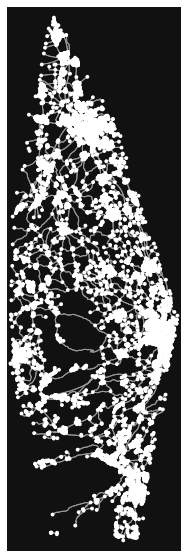

In [ ]:
current_cluster = places.loc[places.cluster == 0]
polys = MultiPolygon(current_cluster.geometry.to_list())
current_region = polys.convex_hull

Network = osmnx.graph_from_polygon(current_region, network_type='drive', retain_all=True, truncate_by_edge=True)
Network = osmnx.project_graph(Network, to_crs='epsg:3857')
fig, ax = osmnx.plot_graph(Network, figsize=(10,10))

In [ ]:
# 3 s per spot
# distances result in meters if epsg is 3857 for Network and Spots -> but both have to be 4326 before !


a = places.loc[places.cluster == 0]
# switch back from circle to point
a['geometry'] = a.apply(lambda x: Point(x.lon, x.lat), axis=1)
a.to_crs(epsg=3857, inplace=True)
def get_nearest_road(row):    
    try:
        return osmnx.distance.nearest_edges(Network, row.geometry.x, row.geometry.y, return_dist=True)
    except:
        return None

a['nearest_road'] = a.apply(get_nearest_road, axis=1)

/home/till/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/till/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/till/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

In [ ]:
# little faster than above, but more api queries

threshold = 0.05 # 100m

def get_nearest_road(row):    
    try:
        N = osmnx.graph_from_point((row.lat, row.lon), dist=200, network_type='drive', retain_all=True, truncate_by_edge=True)
        N = osmnx.projection.project_graph(N, to_crs='epsg:3857')
        return osmnx.distance.nearest_edges(N, row.geometry.x, row.geometry.y, return_dist=True)
    except:
        return None

a['nearest_'] = a.apply(get_nearest_road, axis=1)

/home/till/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
